# Regression Discontinuity Design

This project was done by Alexandra Landry,
Nima Hosseini Abardeh,
Ya Ting Huang,
Kemal Günyel,
Shoaib Khalid.

#### Our task was to use RDD to estimate the effect of the following events in Quebec:

1. The 20/3/2020 lockdown
2. The reopening of schools on 31/8/2020
3. The 25/12/2020 lockdown

Données:
https://www.donneesquebec.ca/recherche/dataset/covid-19-portrait-quotidien-des-cas-confirmes/resource/d2cf4211-5400-46a3-9186-a81e6cd41de9


RDD:
https://ose-data-science.readthedocs.io/en/latest/problem-sets/regression-discontinuity-design/notebook.html
https://medium.com/dataman-in-ai/identify-causality-by-regression-discontinuity-a4c8fb7507df

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import warnings

In [2]:
df = pd.read_csv('COVID19_Qc_RapportINSPQ_HistoVigie.csv')
df = df.drop(index=0)
df['Date'] = pd.to_datetime(df['Date'])
df.columns=['Date','Total_Cases', 'New_Cases', 'Total_Deaths','New_Deaths' ]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466 entries, 1 to 1466
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1466 non-null   datetime64[ns]
 1   Total_Cases   1466 non-null   int64         
 2   New_Cases     1466 non-null   int64         
 3   Total_Deaths  1466 non-null   int64         
 4   New_Deaths    1466 non-null   int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 57.4 KB


In [3]:
df.head()

,Date,Total_Cases,New_Cases,Total_Deaths,New_Deaths
1,2020-01-23,0,0,0,0
2,2020-01-24,0,0,0,0
3,2020-01-25,0,0,0,0
4,2020-01-26,0,0,0,0
5,2020-01-27,0,0,0,0


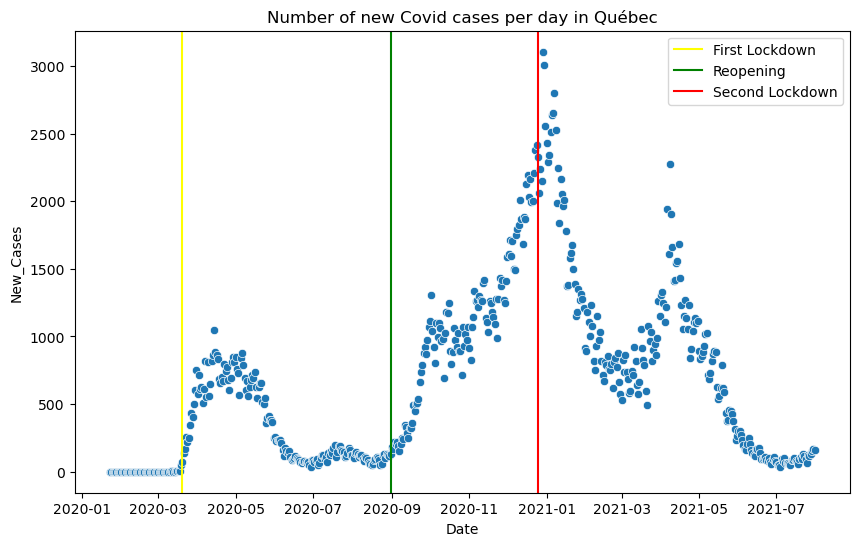

In [4]:
# Visualization of the data (Daily New Covid Cases) with the cutoff dates
ld1 = pd.to_datetime('2020-03-20')
reopen = pd.to_datetime('2020-08-31')
ld2 = pd.to_datetime('2020-12-25')

plt.figure(figsize=(10,6))
sns.scatterplot(x=df['Date'].loc[df['Date']<'2021-08-01'], y=df['New_Cases'])

plt.axvline(x=ld1,color='yellow',label='First Lockdown')
plt.axvline(x=reopen,color='green',label='Reopening')
plt.axvline(x=ld2,color='red',label='Second Lockdown')
plt.title('Number of new Covid cases per day in Québec')
plt.grid(False)
plt.legend()
plt.show()

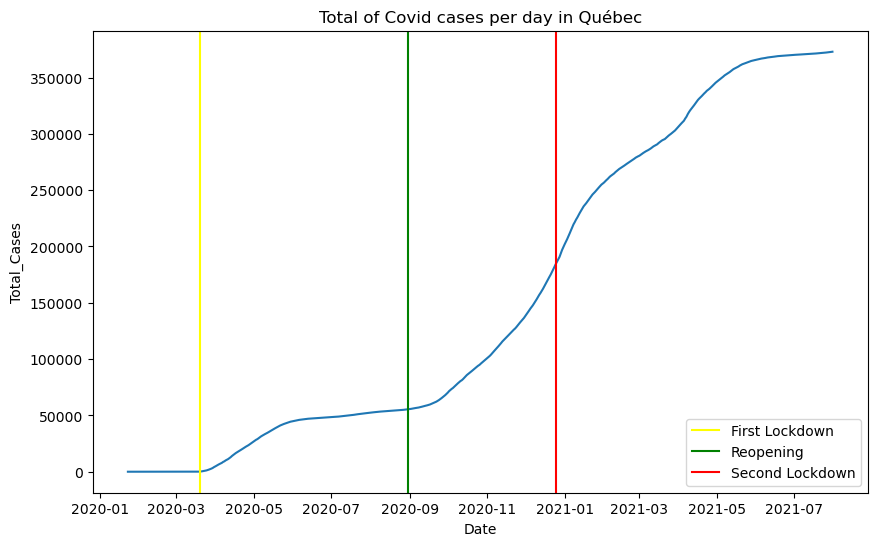

In [5]:
# Visualization of the data (Total Daily Covid deaths) with the cutoff dates
plt.figure(figsize=(10,6))
sns.lineplot(x=df['Date'].loc[df['Date']<'2021-08-01'], y=df['Total_Cases'])

plt.axvline(x=ld1,color='yellow',label='First Lockdown')
plt.axvline(x=reopen,color='green',label='Reopening')
plt.axvline(x=ld2,color='red',label='Second Lockdown')
plt.title('Total of Covid cases per day in Québec')
plt.grid(False)
plt.legend()
plt.show()

# Lockdown 1

In [6]:
def rdd_plot(y_covid, date_cut, delta, order):
    """
    The function is doing a Regression Discontinuity Designs on Covid dataset using OLS from statmodels
    
    
    :param [y_covid]: feature in the covid dataframe selected for the analysis
    :param [date_cut]: cutoff date selected for the analysis
    :param [delta]: number of days in the RDD window before/after date_cut
    :param [oder]: degree for linear regression, 1 or 2 where 2 is polynomial degree 2
    :type [y_covid]: string
    :type [date_cut]: pandas datetime
    :type [delta]: int
    :type [oder]: int    
    
    ...
    return: Summary of OLS regression and plots of the RDD
    """
    
    # Creating the dataset with the selected window from delta
    start_date = date_cut - datetime.timedelta(days=delta)
    end_date = date_cut + datetime.timedelta(days=delta-1)
    df1 = df.loc[df['Date'].between(start_date, end_date)]

    # Fitting the model with the numerical date and the cutoff column - simple model
    # Creating the dummy variable which indicate data before and after the cutoff point
    df1['over_cutoff'] = 0
    df1.loc[df1['Date']>=date_cut,'over_cutoff'] =1 
    df1['over_cutoff'].value_counts()

    # Creating a numerical column for Date
    df1['Num_Date'] = list(range(0,len(df1)))
    #print(df1)
    
    if order == 1:
        # Creating the features dataframe for the model
        X = df1[['Num_Date','over_cutoff']]
        X = sm.add_constant(X)
        y = df1[y_covid]

        # Using OLS and fitting the model
        model1= sm.OLS(y,X).fit(cov_type='HC2')
        print(model1.summary())

        # Ploting the RDD graph
        plt.figure(figsize=(12, 6)) 
        plt.subplot(1,2,1)
        sns.scatterplot(x=df1['Date'],y=df1[y_covid])
        # Adding the to regression line
        l=df1.loc[df1['over_cutoff']==0,'over_cutoff'].count()
        plt.plot(df1['Date'][0:l], model1.predict()[0:l], '-', color="r")
        plt.plot(df1['Date'][l:], model1.predict()[l:], '-', color="r")
        # printing the cutoff date (mid point in the data)
        plt.axvline(x=date_cut,color='black')
        warnings.filterwarnings('ignore')
        plt.xticks(rotation=45)
        plt.title(f'RDD analysis on Covid {y_covid} per day in Québec,\n before and after {date_cut}')
       
        
        plt.subplot(1,2,2)
        sns.regplot(x='Num_Date', y=y_covid, data=df1, order=1,scatter=False)
        # Adding the to regression line
        l=df1.loc[df1['over_cutoff']==0,'over_cutoff'].count()
        plt.plot(df1['Num_Date'][0:l], model1.predict()[0:l], '-', color="r")
        plt.plot(df1['Num_Date'][l:], model1.predict()[l:], '-', color="r")
        # printing the cutoff date (mid point in the data)
        plt.axvline(x=(len(df1)/2),color='black')
        warnings.filterwarnings('ignore')
        plt.xticks(rotation=45)
        plt.title(f'Regression plot of RDD analysis')
        plt.show()
        
    elif order == 2:
        # Creating the freatures dataframe for the model
        df1['Num_Date_poly'] = df1['Num_Date']**2
        X = df1[['Num_Date','Num_Date_poly','over_cutoff']]
        X = sm.add_constant(X)
        y = df1[y_covid]

        # Using OLS and fitting the model
        model1= sm.OLS(y,X).fit(cov_type='HC2')
        print(model1.summary())

        # Ploting the RDD graph
        plt.figure(figsize=(12, 5)) 
        plt.subplot(1,2,1)
        sns.scatterplot(x=df1['Date'],y=df1[y_covid])
        # Adding the to regression line
        l=df1.loc[df1['over_cutoff']==0,'over_cutoff'].count()
        plt.plot(df1['Date'][0:l], model1.predict()[0:l], '-', color="r")
        plt.plot(df1['Date'][l:], model1.predict()[l:], '-', color="r")
        # printing the cutoff date (mid point in the data)
        plt.axvline(x=date_cut,color='black')
        warnings.filterwarnings('ignore')
        plt.xticks(rotation=45)
        plt.title(f'RDD analysis on Covid {y_covid} per day in Québec,\n before and after {date_cut}')
        
        plt.subplot(1,2,2)
        sns.regplot(x='Num_Date', y=y_covid, data=df1, order=2,scatter=False)
        # Adding the to regression line
        l=df1.loc[df1['over_cutoff']==0,'over_cutoff'].count()
        plt.plot(df1['Num_Date'][0:l], model1.predict()[0:l], '-', color="r")
        plt.plot(df1['Num_Date'][l:], model1.predict()[l:], '-', color="r")
        # printing the cutoff date (mid point in the data)
        plt.axvline(x=(len(df1)/2),color='black')
        warnings.filterwarnings('ignore')
        plt.xticks(rotation=45)
        plt.title(f'Regression plot of RDD analysis')
        plt.show()
        
    else:
        return 'Unsupported order, choose 1 or 2'

# Lockdown1

/var/folders/kf/f0s7t2pd5vv6j41cpxj75z4m0000gp/T/ipykernel_11441/2853797586.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['over_cutoff'] = 0
/var/folders/kf/f0s7t2pd5vv6j41cpxj75z4m0000gp/T/ipykernel_11441/2853797586.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Num_Date'] = list(range(0,len(df1)))


                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     39.49
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           4.07e-07
Time:                        14:34:14   Log-Likelihood:                -111.38
No. Observations:                  20   AIC:                             228.8
Df Residuals:                      17   BIC:                             231.8
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -98.8045     39.891     -2.477      

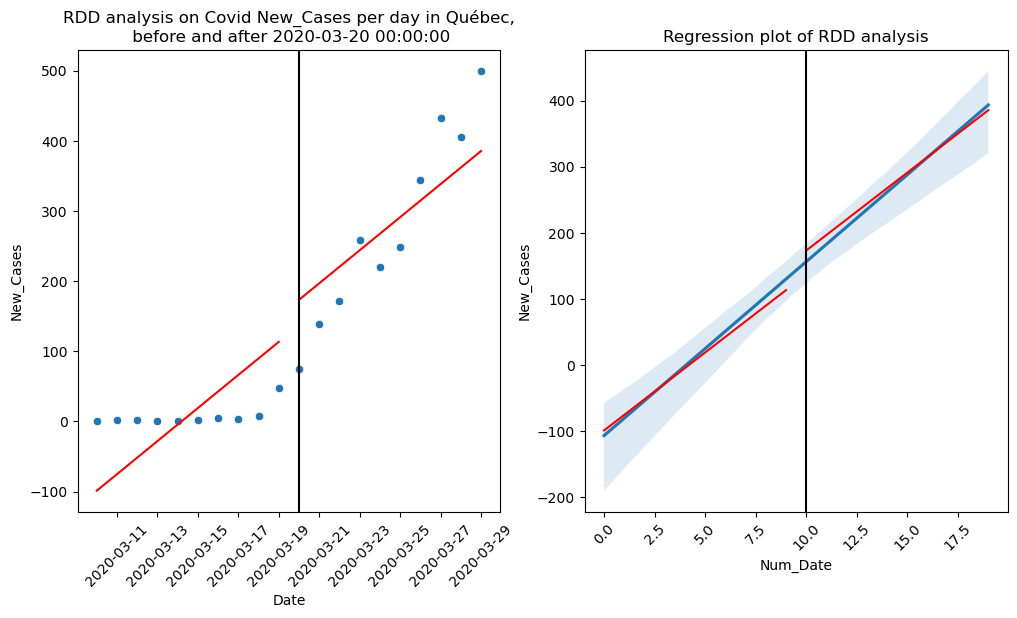

In [7]:
rdd_plot('New_Cases', ld1, 10, 1)

                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     191.6
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           2.08e-29
Time:                        14:34:14   Log-Likelihood:                -358.48
No. Observations:                  60   AIC:                             725.0
Df Residuals:                      56   BIC:                             733.3
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.8510     13.564      1.685

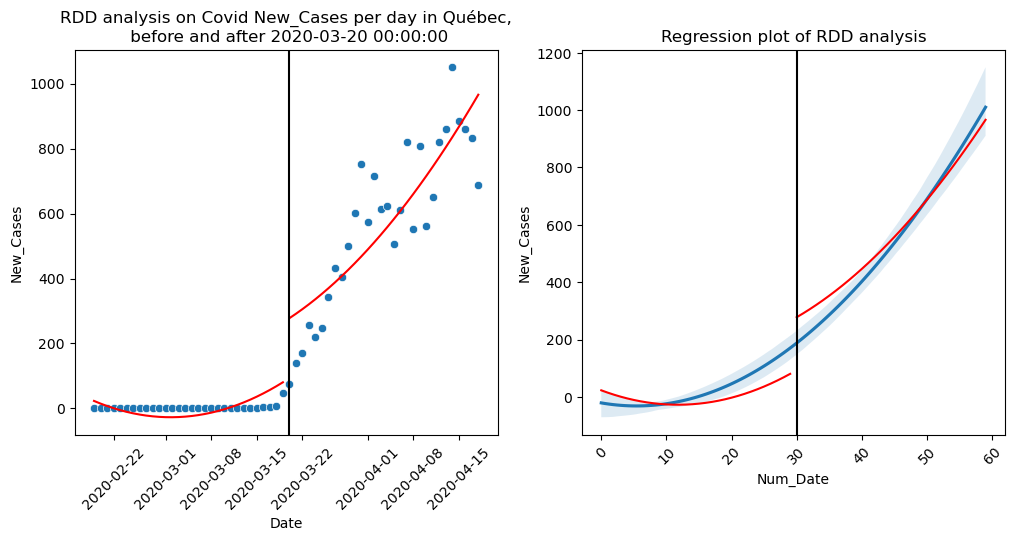

In [8]:
rdd_plot('New_Cases', ld1, 30, 2)

                            OLS Regression Results                            
Dep. Variable:             New_Deaths   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     264.0
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           5.29e-33
Time:                        14:34:15   Log-Likelihood:                -191.40
No. Observations:                  60   AIC:                             390.8
Df Residuals:                      56   BIC:                             399.2
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.0853      1.929      3.673

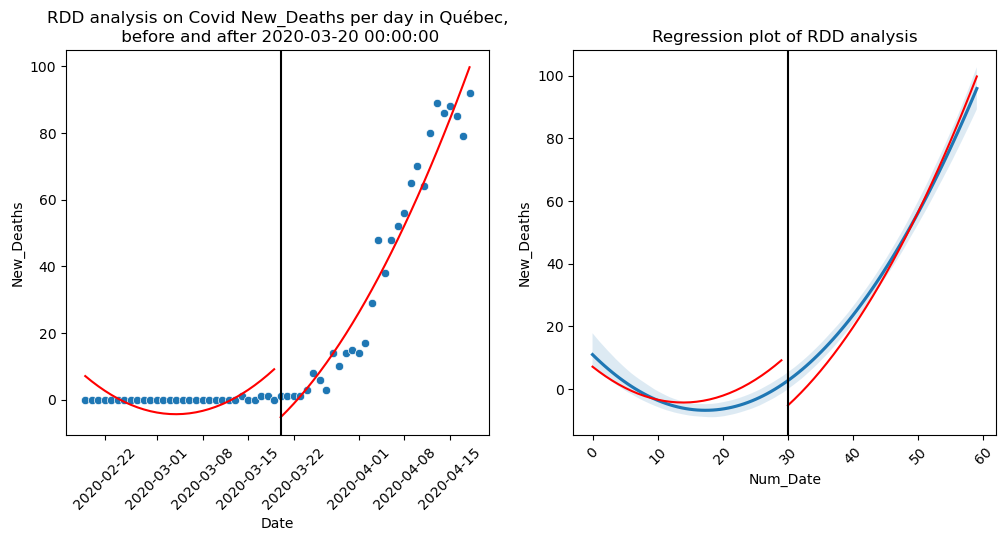

In [9]:
rdd_plot('New_Deaths', ld1, 30, 2)

On the table, we can see that the coefficient for the lockdown variable (over_cutoff) is 184. This indicates a substantial increase in the daily new COVID cases after the 20th of March 2020.

-On the table we can also see that the P-value of the lockdown variable is 0.001. This suggests that the observed difference is statistically significant.

-First:  Before the lockdown, the increase in COVID-19 cases was slow. This suggests that the number of cases was gradually rising over time without the lockdown.

-Second: On the graph we can see that after the lockdown, there was a noticeable change in the pattern. At the beginning of the lockdown,  there was a sharp and significant increase in COVID-19 cases. This increase may imply that more people started to get tested, and the virus incubation period have ended.

# School reopening

                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     259.6
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           8.18e-33
Time:                        14:34:15   Log-Likelihood:                -320.89
No. Observations:                  60   AIC:                             649.8
Df Residuals:                      56   BIC:                             658.2
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           181.6833     15.753     11.534

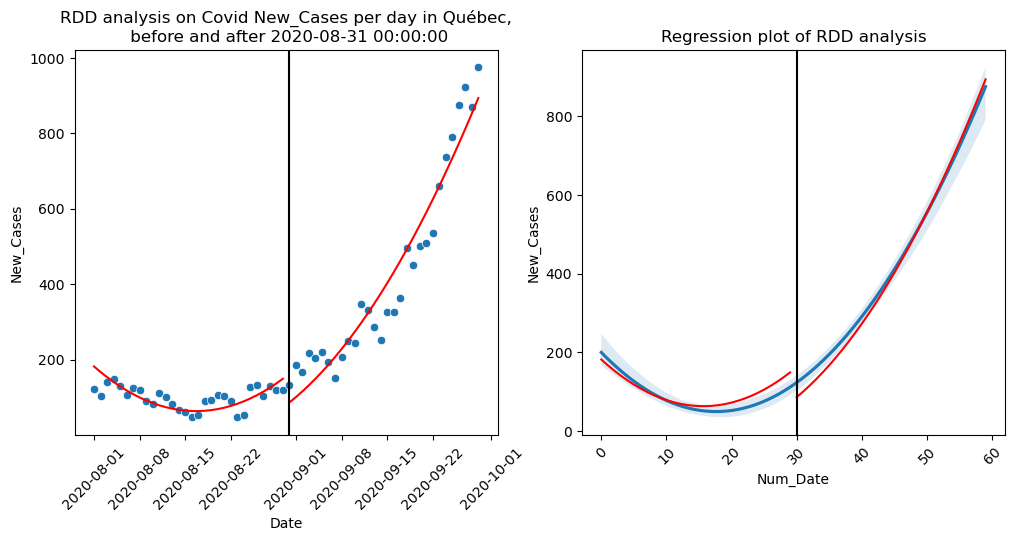

In [10]:
rdd_plot('New_Cases', reopen, 30, 2)

                            OLS Regression Results                            
Dep. Variable:             New_Deaths   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     9.375
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           4.07e-05
Time:                        14:34:16   Log-Likelihood:                -110.52
No. Observations:                  60   AIC:                             229.0
Df Residuals:                      56   BIC:                             237.4
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.0725      0.581      3.569

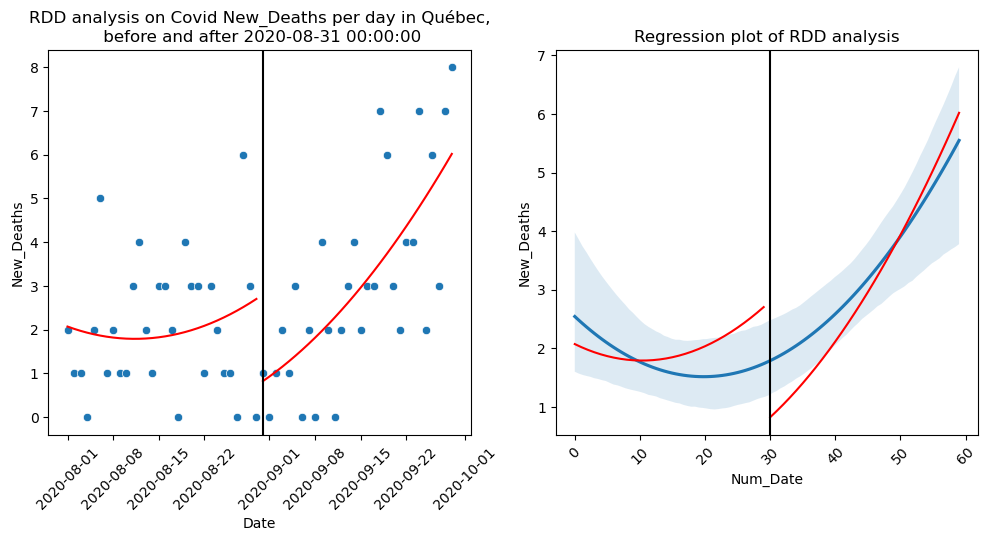

In [11]:
#JUST A COMPARISON
## New_Deaths is not changing that much compare to the increase of case after reopening the school. 
## Which make sense as younger people were less affected by the virus.
rdd_plot('New_Deaths', reopen, 30, 2)

School reopening also had a positive impact on the number of COVID cases.

After schools reopened on the 31st of August 2020, the number of cases looks steady. However, 30 days after reopening, cases began to increase rapidly.  This again can be due to the end of virus incubation period.

Despite wearing masks and social distancing, students were at a greater risk of contracting the disease.
but it is a little bit difficult to supervise children every second to see if they were following the rules of wearing mask and social distancing.

Therefore, after schools reopened, the number of cases increased while the the number of deaths did not increase but stabilised. This may suggest that children and young people could handle virus better than older people.

# Lockdown2

                            OLS Regression Results                            
Dep. Variable:              New_Cases   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     82.13
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           3.07e-22
Time:                        14:34:16   Log-Likelihood:                -476.15
No. Observations:                  70   AIC:                             960.3
Df Residuals:                      66   BIC:                             969.3
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           917.2878     63.551     14.434

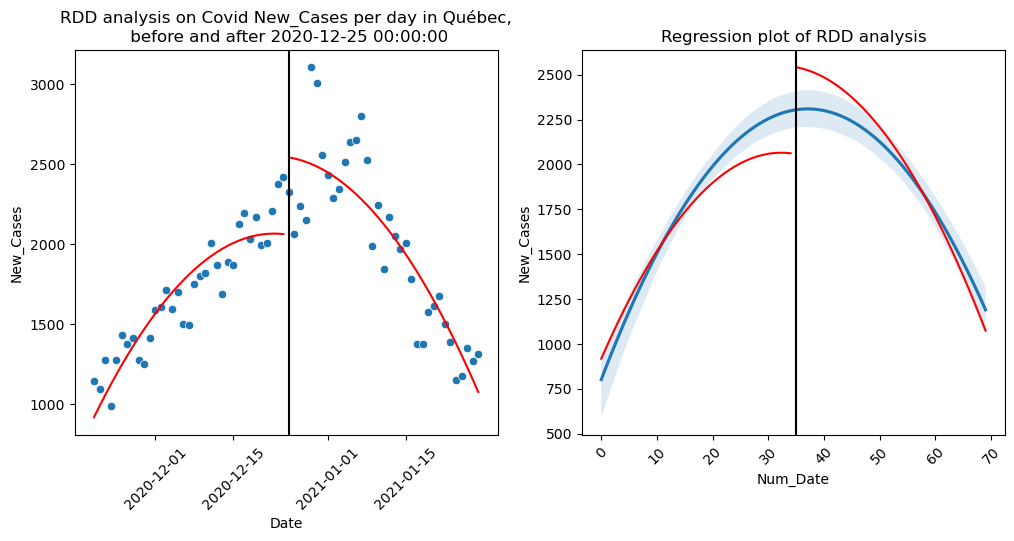

In [12]:
rdd_plot('New_Cases', ld2, 35, 2)

Lockdown 2 in December 2020 initially had more people getting sick, especially during the holiday season when folks gathered more. After that, there was a decrease in cases, which could be explained by the lockdown and people being more careful. Looking at the timeline here: https://en.wikipedia.org/wiki/Timeline_of_the_COVID-19_pandemic_in_Quebec, the first vaccine was given on December 14, 2020, mostly to older folks and those who were at higher risk for Covid(ex: people with already weak immune systems.) If you check the 'New_Deaths' part, you'll see fewer people died after the lockdown. A new variant of the virus was discovered on December 29. It seems like people took the second lockdown more seriously than the first one. By July 6, 2020, everyone had to wear masks, and Covid tests were more widely available.

                            OLS Regression Results                            
Dep. Variable:             New_Deaths   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     104.1
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           9.26e-33
Time:                        14:34:17   Log-Likelihood:                -405.79
No. Observations:                 120   AIC:                             819.6
Df Residuals:                     116   BIC:                             830.7
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.5338      1.746      7.179

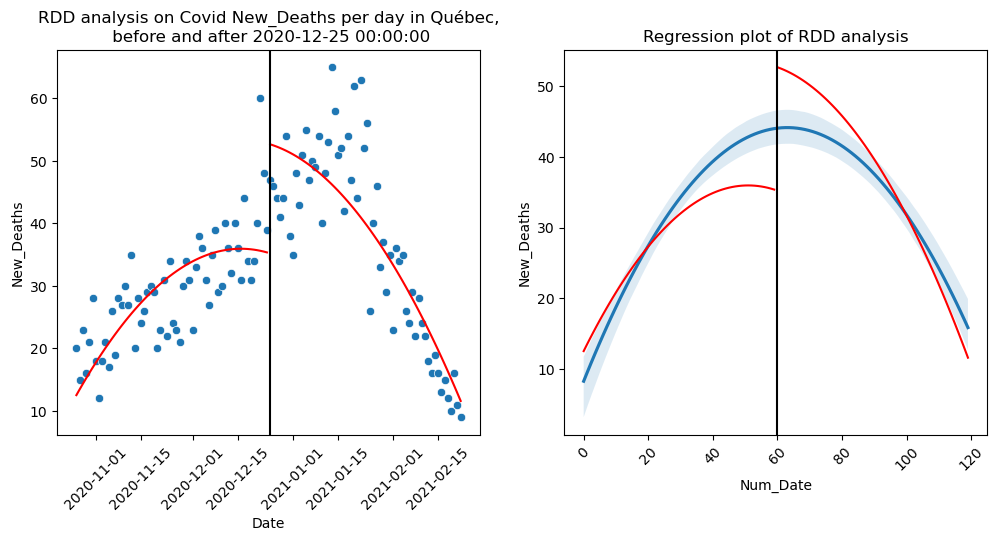

In [13]:
#Simply an example of New Deaths at a 60 day window of the 2nd lockdown.
rdd_plot('New_Deaths', ld2, 60, 2)

In summary, the study emphasizes how lockdowns played a big role in slowing down the spread of Covid-19, even though it took some time to see the full effect. Reopening schools, despite trying to be careful, led to more cases. Lockdown 2 in December 2020 had more people getting sick at first due to holiday gatherings, but later on, cases went down. This matches with the start of vaccinations and people becoming more aware. The timeline shows how people's attitude changed, moving from not taking things seriously to being more careful. This shift was supported by rules like wearing masks, more available Covid tests, and a better understanding of the virus's risks. 